In [19]:
import pandas as pd
import numpy as np

In [169]:
data = pd.read_csv("Manhattan_reviews_closed_10.csv")
data2 = pd.read_csv('Manhattan__openreviews_10.csv')

In [133]:
#data = pd.read_csv("Brooklyn_reviews_closed_10.csv")
#data2 = pd.read_csv('Brooklyn_openreviews_10.csv')

In [170]:
data = data.drop(['name'], axis=1)
stacked = data.stack().reset_index(drop=True)
df = pd.DataFrame(stacked,columns=['review'])
df['is_closed']=1

data2 = data2.drop(['name'], axis=1)
stacked = data2.stack().reset_index(drop=True)
df2 = pd.DataFrame(stacked,columns=['review'])
df2['is_closed']=0

df=df.append(df2)

In [171]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    text = [t for t in text if len(t) > 0]
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)


df["review_clean"] = df["review"].apply(lambda x: clean_text(x))

In [172]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
df = pd.concat([df, doc2vec_df], axis=1)

In [173]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=2,stop_words='english')
tfidf_result = tfidf.fit_transform(df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index
df = pd.concat([df, tfidf_df], axis=1)

In [175]:
df.shape

(1350, 3937)

In [174]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
df["sentiments"] = df["review"].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)

In [176]:
# feature selection
label = "is_closed"
ignore_cols = [label, "review", "review_clean"]
features = [c for c in df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[features], df[label], test_size = 0.20, random_state = 42)

In [177]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(10)

,feature,importance
3930,neg,0.011787
3933,compound,0.011639
1333,word_food,0.010941
250,word_bar,0.010675
3931,neu,0.010500
258,word_bartender,0.010438
3932,pos,0.009945
4,doc2vec_vector_4,0.007704
1,doc2vec_vector_1,0.007624
3,doc2vec_vector_3,0.007056


In [132]:
from sklearn.metrics import confusion_matrix 
pd.DataFrame(confusion_matrix(y_test, svm.predict(X_test), labels=[0, 1])) 

,0,1
0,174,13
1,51,32


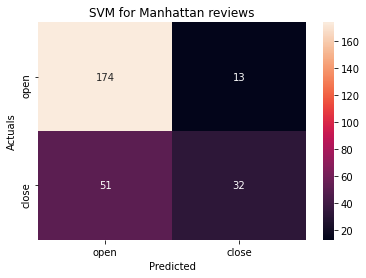

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

cm = pd.DataFrame(confusion_matrix(y_test, svm.predict(X_test), labels=[0, 1])) 
LABELS = ['open', 'close']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g').set_title("SVM for Manhattan reviews")

xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

In [162]:
from sklearn.metrics import classification_report
predicted = rf.predict(X_test)
print(classification_report(y_test, predicted, target_names=LABELS))

              precision    recall  f1-score   support

        open       0.73      0.99      0.84       187
       close       0.87      0.16      0.27        83

    accuracy                           0.73       270
   macro avg       0.80      0.57      0.55       270
weighted avg       0.77      0.73      0.66       270



In [178]:
#RF
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc,precision_recall_curve

predicted = rf.predict(X_test)
f1_score = f1_score(y_test, predicted,average='macro')

predict_p=rf.predict_proba(X_test)
y_pred = predict_p[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

print('f1 macro:', '%.4f'%f1_score)
print("AUC: {:.4}".format(auc(fpr, tpr)))

f1 macro: 0.5555
AUC: 0.7717


In [163]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', max_iter=100, C=1, random_state=42)
lr.fit(X_train, y_train)
lr_cv_scores = cross_val_score(lr, X_train,  y_train, cv=5)
lr_cv_mean_score = np.mean(lr_cv_scores)
lr_test_score = lr.score(X_test, y_test)
print('Mean CV Accuracy:', lr_cv_mean_score )
print('Test Accuracy:', lr_test_score)

Mean CV Accuracy: 0.7305555555555555
Test Accuracy: 0.7407407407407407


In [125]:
from sklearn.svm import LinearSVC

svm = LinearSVC(penalty='l2', C=1, random_state=42)
svm.fit(X_train, y_train)
svm_cv_scores = cross_val_score(svm, X_train,  y_train, cv=5)
svm_cv_mean_score = np.mean(svm_cv_scores)
svm_test_score = svm.score(X_test, y_test)
print('Mean CV Accuracy:', svm_cv_mean_score)
print('Test Accuracy:', svm_test_score)

Mean CV Accuracy: 0.7833333333333334
Test Accuracy: 0.762962962962963


In [127]:
from sklearn.metrics import classification_report
predicted = svm.predict(X_test)
print(classification_report(y_test, predicted, target_names=LABELS))

              precision    recall  f1-score   support

        open       0.77      0.93      0.84       187
       close       0.71      0.39      0.50        83

    accuracy                           0.76       270
   macro avg       0.74      0.66      0.67       270
weighted avg       0.75      0.76      0.74       270



In [164]:
from sklearn.linear_model import SGDClassifier

svm_sgd = SGDClassifier(loss='hinge', penalty='l2',  random_state=42)
svm_sgd.fit(X_train, y_train)
svmsgd_cv_scores = cross_val_score(svm_sgd, X_train,  y_train, cv=5)
svmsgd_cv_mean_score = np.mean(svmsgd_cv_scores)
svmsgd_test_score = svm_sgd.score(X_test, y_test)
print('Mean CV Accuracy:', svmsgd_cv_mean_score)
print('Test Accuracy:', svmsgd_test_score)

Mean CV Accuracy: 0.7712962962962963
Test Accuracy: 0.7592592592592593


In [165]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=10, random_state=42)
gbc.fit(X_train, y_train)
gbc_cv_scores = cross_val_score(gbc, X_train, y_train, cv=5)
gbc_cv_mean_score = np.mean(gbc_cv_scores)
gbc_test_score = gbc.score(X_test, y_test)
print('Mean CV Accuracy:', gbc_cv_mean_score )
print('Test Accuracy:', gbc_test_score)

Mean CV Accuracy: 0.711111111111111
Test Accuracy: 0.7


In [185]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
rfc_cv_scores = cross_val_score(rfc, X_train, y_train, cv=5)
rfc_cv_mean_score = np.mean(rfc_cv_scores)
rfc_test_score = rfc.score(X_test, y_test)
print('Mean CV Accuracy:', rfc_cv_mean_score )
print('Test Accuracy:', rfc_test_score)

Mean CV Accuracy: 0.725
Test Accuracy: 0.7296296296296296


In [ ]:
#To make prediction on the new data set

#Load the data the same you load your test set
#Apply all the per-processing steps applied on your training set.
#Use the model.predict(X)


In [139]:
# feature selection
label = "is_closed"
ignore_cols = [label, "review", "review_clean"]
features = [c for c in df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

B_train, B_test, b_train, b_test = train_test_split(df[features], df[label], test_size = 0.20, random_state = 42)

In [141]:
# Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( B_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    B_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
B_test = B_test[X_train.columns]

In [144]:
#Prediction on Brooklyn
from sklearn.metrics import classification_report
predicted = svm.predict(B_test)
print(classification_report(b_test, predicted, target_names=LABELS))

              precision    recall  f1-score   support

        open       0.77      0.84      0.80        89
       close       0.36      0.26      0.30        31

    accuracy                           0.69       120
   macro avg       0.56      0.55      0.55       120
weighted avg       0.66      0.69      0.67       120



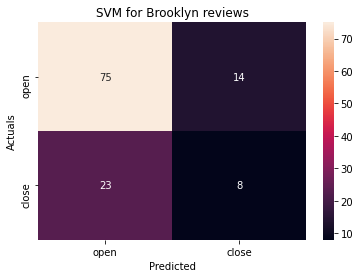

In [149]:
cm = pd.DataFrame(confusion_matrix(b_test, svm.predict(B_test), labels=[0, 1])) 
LABELS = ['open', 'close']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g').set_title("SVM for Brooklyn reviews")

xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

In [184]:
predict_p=rf.predict_proba(B_test)
y_pred = predict_p[:,1]
fpr, tpr, thresholds = roc_curve(b_test, y_pred)
print("AUC: {:.4}".format(auc(fpr, tpr)))

AUC: 0.643
